In [1]:
import pandas as pd
import re
import numpy as np
import random
import openai
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
file_path = '3026NMfixed_UT.csv'
data = pd.read_csv(file_path)

In [3]:
# Function to clean text; combines all parts of an utterance
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.strip()

In [4]:
# Apply the cleaning function to the utterances
data['cleaned_utterance'] = data['utterance'].apply(clean_text)

# Combine Speaker and cleaned utterance columns for better context
data['text'] = data['Speaker'].astype(str) + ' ' + data['cleaned_utterance']

In [5]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])

# Encode labels (ut column)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['ut'])

In [6]:
# Function to build the neural network model
def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
# Train and evaluate model over different training percentages
training_percentages = [0.2, 0.4, 0.6, 0.8]
results = []


for train_percentage in training_percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_percentage, random_state=42)
    model = build_model(X.shape[1])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    results.append((train_percentage, score[1]))
    print(f"Training Percentage: {train_percentage * 100:.0f}%, Test Accuracy: {score[1] * 100:.2f}%")

Training Percentage: 20%, Test Accuracy: 22.79%
Training Percentage: 40%, Test Accuracy: 31.86%
Training Percentage: 60%, Test Accuracy: 38.94%
Training Percentage: 80%, Test Accuracy: 39.82%


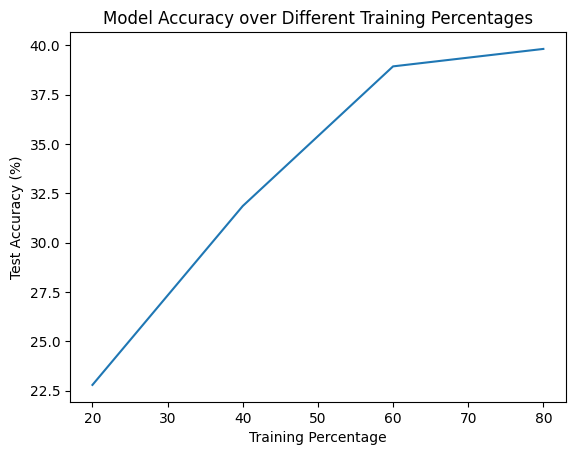

In [8]:
# Plot accuracy over different training percentages
train_percentages, accuracies = zip(*results)
plt.plot(np.array(train_percentages) * 100, np.array(accuracies) * 100)
plt.xlabel('Training Percentage')
plt.ylabel('Test Accuracy (%)')
plt.title('Model Accuracy over Different Training Percentages')
plt.show()

In [9]:
# Display results in a DataFrame
results_df = pd.DataFrame(results, columns=['Training Percentage', 'Test Accuracy'])
print(results_df)

   Training Percentage  Test Accuracy
0                  0.2       0.227876
1                  0.4       0.318584
2                  0.6       0.389381
3                  0.8       0.398230


In [23]:
# Genetic Algorithm for Classification
num_clusters = 16
population_size = 10
num_generations = 5
openai.api_key = ''
classification_cache = {}
def classify_utterances(utterances, speakers):
    classifications = []
    not_cached_utterances, not_cached_speakers, not_cached_indices = [], [], []

    for idx, (utterance, speaker) in enumerate(zip(utterances, speakers)):
        if utterance in classification_cache:
            classifications.append(classification_cache[utterance])
        else:
            not_cached_utterances.append(utterance)
            not_cached_speakers.append(speaker)
            not_cached_indices.append(idx)

    if not_cached_utterances:
        batch_prompt = f"""Classify the following utterances based on the provided coding scheme and the following rules:
        1. When the speaker is 'S' the possible classifications are Ry, Rs, and Rq.
        2. When the speaker is 'T' the classifications of Ry, Rs, and Rq are not possible.

        Coding Scheme:
        For Teacher (T):
        • Q - Question: An inquiry posed to the student. Example: “Can you explain the water cycle?”
        • P - Prompt: A cue aimed to guide the student’s response or thought process. Example: “Think about the plant in sunlight.”
        • E - Example/Explanation: Offering detailed information or illustrating a concept. Example: “Photosynthesis is when plants convert sunlight into energy.”
        • F - Feedback: Providing input on a student's statement or answer.
          1) Fy - Confirmatory Feedback: Affirming the correctness of a student’s answer or repeating students’ responses. Example: “That's right!” 
          2) Fs - Feedback with Statements: Providing feedback with additional information. Example: “Yes, and it also involves carbon dioxide.”
          3) Fq - Feedback with a Question: Giving feedback and further probing the student. Example: “Correct. Now, what's its role in the food chain?”
        • NA – Inaudible or Meaningless: Any utterance that is unclear or unrelated.

        For Student (S):
        • R - Response: Replies to teacher's questions or prompts.
          1) Ry - Confirmatory responses: Agreement or acknowledgment. Example: “Yes, I understand.” 
          2) Rs - Response with statement: Providing an answer or viewpoint. Example: “Photosynthesis is a plant’s way of creating energy.”
          3) Rq – Response with a question: Further inquiry based on the discussion. Example: “But why do plants need sunlight specifically?”
        • NA – Inaudible or meaningless: Cannot be discerned or lacks educational relevance.

        Utterances: {json.dumps(list(zip(not_cached_indices, not_cached_speakers, not_cached_utterances)))}

        Return the classifications in the following format:
        index: classification
        """

        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": batch_prompt}
            ]
        )

        response_text = response['choices'][0]['message']['content'].strip()
        responses = [line.strip() for line in response_text.split('\n') if line.strip()]

        parsed_responses = {}
        for line in responses:
            try:
                idx, classification = line.split(': ', 1)
                parsed_responses[int(idx)] = classification.strip()
            except ValueError as e:
                print(f"Error parsing line: {line}\nException: {e}")

        for i, idx in enumerate(not_cached_indices):
            if idx in parsed_responses:
                classification = parsed_responses[idx]
                speaker = not_cached_speakers[i]
                if speaker == 'S' and classification not in ['Ry', 'Rs', 'Rq']:
                    classification = 'NA'
                elif speaker == 'T' and classification in ['Ry', 'Rs', 'Rq']:
                    classification = 'NA'
                classifications.append(classification)
                classification_cache[not_cached_utterances[i]] = classification
            else:
                classifications.append('NA')  # Handle missing classifications with a default value
                print(f"Warning: Missing classification for utterance index {idx}")

    return classifications

In [24]:
# Test the batch classification function
example_utterances = data['cleaned_utterance'].iloc[:10].tolist()
example_speakers = data['Speaker'].iloc[:10].tolist()
classify_utterances(example_utterances, example_speakers)

['Q', 'P', 'NA', 'NA', 'Rs', 'Q', 'Ry', 'Q', 'Rs', 'Fy']

In [25]:
def fitness_function(individual):
    utterances = [data['cleaned_utterance'].iloc[idx] for idx in range(len(individual))]
    speakers = [data['Speaker'].iloc[idx] for idx in range(len(individual))]
    classifications = classify_utterances(utterances, speakers)
    
    # Calculate fitness based on the consistency and quality of classifications
    fitness = calculate_fitness(classifications)
    return fitness

In [26]:
def calculate_fitness(classifications):
    # Example fitness function based on the number of correct classifications
    correct_count = sum([1 for c in classifications if c in data['ut'].values])
    return correct_count / len(classifications)

In [27]:
def selection(population, fitnesses):
    return random.choices(population, weights=fitnesses, k=len(population))

In [28]:
def crossover(parent1, parent2):
    crossover_point = random.randint(0, len(parent1) - 1)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

In [29]:
def mutate(individual, mutation_rate=0.01):
    for idx in range(len(individual)):
        if random.random() < mutation_rate:
            individual[idx] = random.randint(0, num_clusters - 1)
    return individual

In [30]:
def genetic_algorithm():
    population = [np.random.randint(0, num_clusters, size=data.shape[0]) for _ in range(population_size)]
    performance_scores = []
    missing_classifications = []
    
    for generation in range(num_generations):
        fitnesses = []
        missing_counts = []
        
        for ind in population:
            fitness = fitness_function(ind)
            classifications = classify_utterances(
                [data['cleaned_utterance'].iloc[idx] for idx in range(len(ind))],
                [data['Speaker'].iloc[idx] for idx in range(len(ind))]
            )
            missing_count = sum([1 for c in classifications if c == 'NA'])
            
            fitnesses.append(fitness)
            missing_counts.append(missing_count)
        
        avg_fitness = np.mean(fitnesses)
        avg_missing_classifications = np.mean(missing_counts)
        
        performance_scores.append(avg_fitness)
        missing_classifications.append(avg_missing_classifications)
        
        new_population = []
        
        for _ in range(population_size // 2):
            parent1, parent2 = random.sample(population, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])
        
        population = new_population
        print(f"Generation {generation + 1}, Average Fitness: {avg_fitness}, Avg Missing Classifications: {avg_missing_classifications}")

    best_individual = max(population, key=fitness_function)
    return best_individual, performance_scores, missing_classifications

In [31]:
# Run the genetic algorithm
best_solution, performance_scores, missing_classifications = genetic_algorithm()

Generation 1, Average Fitness: 0.45345132743362837, Avg Missing Classifications: 305.8
Generation 2, Average Fitness: 0.45840707964601773, Avg Missing Classifications: 306.0
Generation 3, Average Fitness: 0.45840707964601773, Avg Missing Classifications: 306.0
Generation 4, Average Fitness: 0.45840707964601773, Avg Missing Classifications: 306.0
Generation 5, Average Fitness: 0.45840707964601773, Avg Missing Classifications: 306.0


In [32]:
# Classify utterances based on the best solution
data['classified_code'] = [classify_utterances([data['cleaned_utterance'].iloc[idx]], [data['Speaker'].iloc[idx]])[0] for idx in range(data.shape[0])]

In [33]:
# Save the results
data.to_csv('3026NMfixed_UT_classified.csv', index=False)

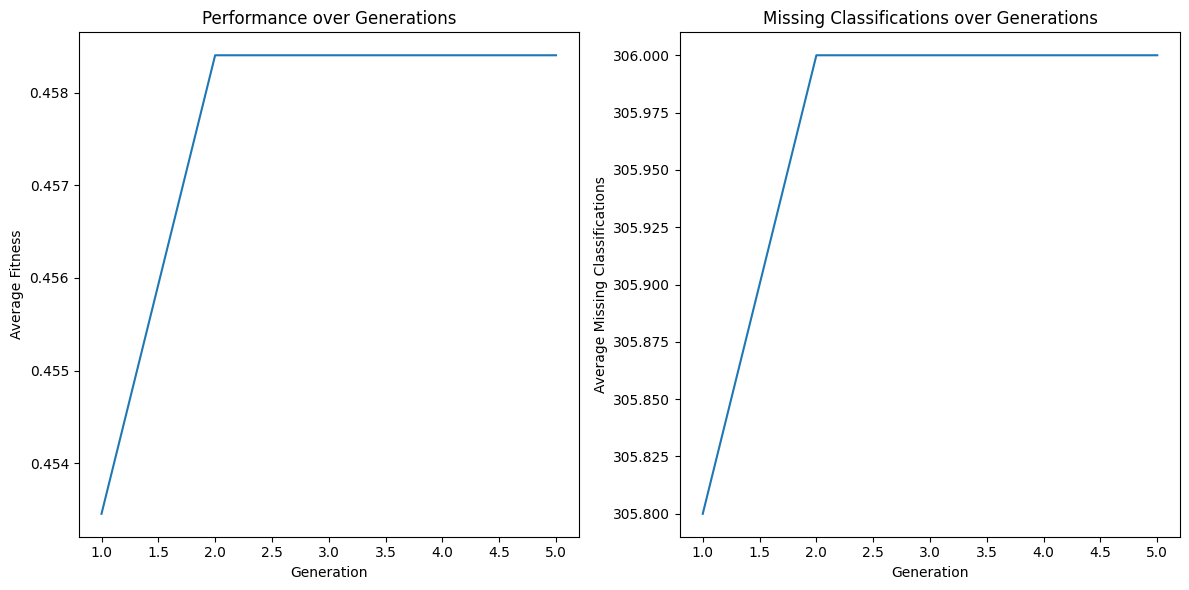

In [34]:
# Generate a performance graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_generations + 1), performance_scores)
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('Performance over Generations')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_generations + 1), missing_classifications)
plt.xlabel('Generation')
plt.ylabel('Average Missing Classifications')
plt.title('Missing Classifications over Generations')

plt.tight_layout()
plt.show()

In [35]:
# Create a table of parameters and their values
parameters = {
    "Number of Generations": num_generations,
    "Population Size": population_size,
    "Number of Clusters": num_clusters,
    "Mutation Rate": 0.01,
    "Best Fitness Score": max(performance_scores),
    "Average Missing Classifications": np.mean(missing_classifications)
}

parameters_df = pd.DataFrame(list(parameters.items()), columns=['Parameter', 'Value'])
print(parameters_df)

                         Parameter       Value
0            Number of Generations    5.000000
1                  Population Size   10.000000
2               Number of Clusters   16.000000
3                    Mutation Rate    0.010000
4               Best Fitness Score    0.458407
5  Average Missing Classifications  305.960000
